In [116]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize

In [117]:
df_forecast = pd.read_csv('2.Прогноз_ПХГ.csv', skiprows=1, 
                          names=('date', 'forecast'), encoding='latin-1')
df_forecast.head()

,date,forecast
0,2021-11-01,15.46
1,2021-11-02,15.93
2,2021-11-03,16.41
3,2021-11-04,16.90
4,2021-11-05,17.00


In [118]:
def max_efficiency_phg1(x):
    return 5 + 0.0000001*(x**3) + 0.00004*(x**2) - 0.02*x

def max_efficiency_phg2(x):
    return 10 - 0.00006*(x**2) + 0.05*x
    
def max_efficiency_sum(x1, x2):
    return max_efficiency_phg1(x1) + max_efficiency_phg2(x2)

In [119]:
print(f'Максимальная суточная производительность первого ПХГ при заполненности на 450 млн куб. м: {max_efficiency_phg1(450)}')
print(f'Максимальная суточная производительность второго ПХГ при заполненности на 450 млн куб. м: {max_efficiency_phg2(450)}')
print(f'Максимальная суммарная суточная производительность первого и второго ПХГ при заполненности на 450 млн куб. м: {max_efficiency_sum(450, 450)}')

Максимальная суточная производительность первого ПХГ при заполненности на 450 млн куб. м: 13.212499999999999
Максимальная суточная производительность второго ПХГ при заполненности на 450 млн куб. м: 20.35
Максимальная суммарная суточная производительность первого и второго ПХГ при заполненности на 450 млн куб. м: 33.5625


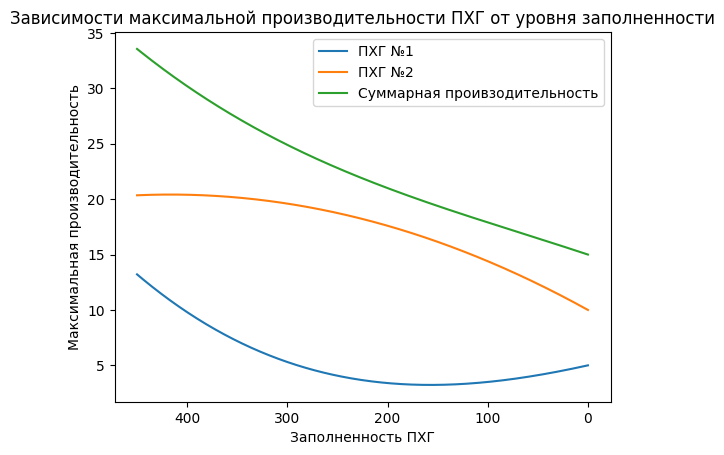

In [120]:
plt.plot(np.arange(451), max_efficiency_phg1(np.arange(451)))
plt.plot(np.arange(451), max_efficiency_phg2(np.arange(451)))
plt.plot(np.arange(451), max_efficiency_sum(np.arange(451), np.arange(451)))
plt.xlabel('Заполненность ПХГ')
plt.ylabel('Максимальная производительность')
plt.title('Зависимости максимальной производительности ПХГ от уровня заполненности')
plt.legend(['ПХГ №1', 'ПХГ №2', 'Суммарная проивзодительность'])
plt.gca().invert_xaxis()

In [121]:
# Определение начальных условий
forecast = df_forecast['forecast'].values
period = len(forecast)
x0 = np.zeros(2*period)

# Определение функции для расчета целевой функции
def objective_function(x):
    start_fullness_1 = 450
    start_fullness_2 = 450
    x1, x2 = x[:period], x[period:]
    production1 = max_efficiency_phg1(start_fullness_1 - np.cumsum(x1)[-1])
    production2 = max_efficiency_phg2(start_fullness_2 - np.cumsum(x2)[-1])
    return -(production1 + production2)

# Определение ограничений на переменные
def constraint1(x):
    x1, x2 = x[:period], x[period:]
    current_fullness_1 = 450
    current_fullness_2 = 450
    constraint_values = np.zeros(2*period)
    for i in range(period):
        current_fullness_1 -= x1[i]
        current_fullness_2 -= x2[i]
        constraint_values[i] = max_efficiency_phg1(current_fullness_1) - x1[i]
        constraint_values[i+period] = max_efficiency_phg2(current_fullness_2) - x2[i]
    return np.array(constraint_values)

def constraint2(x):
    x1, x2 = x[:period], x[period:]
    return x1 + x2 - forecast

# Определение ограничений
con1 = {'type': 'ineq', 'fun': lambda x: constraint1(x)}
con2 = {'type': 'eq', 'fun': lambda x: constraint2(x)}

# Решение задачи
res = minimize(objective_function, x0, method='SLSQP', constraints=[con1, con2])

print("Значение целевой функции при оптимальных отборах:", -res.fun)
print("Оптимальные значения отборов ПХГ1:", res.x[:period])
print("Оптимальные значения отборов ПХГ2:", res.x[period:])

Значение целевой функции при оптимальных отборах: 19.99698833225491
Оптимальные значения отборов ПХГ1: [12.29511845 11.48499304 10.76582532 10.12434325  9.54964613  9.03271022
  8.566011    8.14323179  7.75903665  7.40889187  7.08892444  6.79580901
  6.52667689  6.27904238  6.05074257  5.83988814  5.64482258  5.46408851
  5.2963995   5.14061654  4.9957282   4.86083385  4.73512947  4.61789551
  4.50848655  4.40632238  4.31088039  4.22168892  4.13832156  4.06039213]
Оптимальные значения отборов ПХГ2: [ 3.16488155  4.44500696  5.64417468  6.77565675  7.45035387  7.96728978
  8.433989    8.85676821  9.24096335  9.59110813  9.91107556 10.20419099
 10.47332311 10.72095762 10.94925743 11.16011186 11.35517742 11.53591149
 11.7036005  11.85938346 12.0042718  12.13916615 12.26487053 12.38210449
 12.49151345 12.59367762 12.68911961 12.77831108 12.86167844 12.93960787]


In [122]:
df_final = df_forecast

df_final['phg1_extract'] = res.x[:period]
df_final['phg2_extract'] = res.x[period:]

df_final['phg1_left'] = 450 - np.cumsum(df_final['phg1_extract'])
df_final['phg2_left'] = 450 - np.cumsum(df_final['phg2_extract'])
df_final.head()

,date,forecast,phg1_extract,phg2_extract,phg1_left,phg2_left
0,2021-11-01,15.46,12.295118,3.164882,437.704882,446.835118
1,2021-11-02,15.93,11.484993,4.445007,426.219889,442.390111
2,2021-11-03,16.41,10.765825,5.644175,415.454063,436.745937
3,2021-11-04,16.90,10.124343,6.775657,405.329720,429.970280
4,2021-11-05,17.00,9.549646,7.450354,395.780074,422.519926


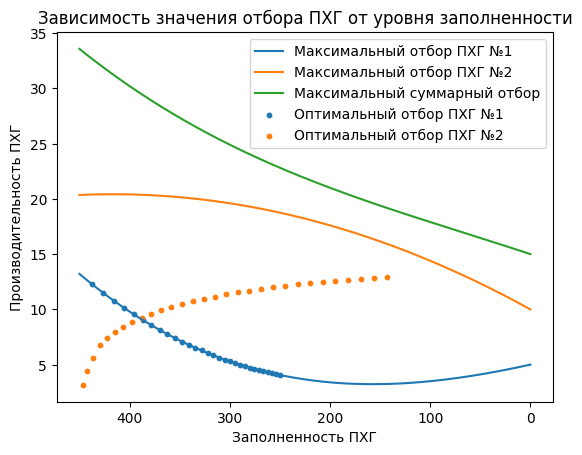

In [123]:
plt.plot(np.arange(451), max_efficiency_phg1(np.arange(451)))
plt.plot(np.arange(451), max_efficiency_phg2(np.arange(451)))
plt.plot(np.arange(451), max_efficiency_phg1(np.arange(451)) + max_efficiency_phg2(np.arange(451)))
plt.scatter(df_final['phg1_left'], df_final['phg1_extract'], s=10)
plt.scatter(df_final['phg2_left'], df_final['phg2_extract'], s=10)
plt.xlabel('Заполненность ПХГ')
plt.ylabel('Производительность ПХГ')
plt.title('Зависимость значения отбора ПХГ от уровня заполненности')
plt.legend(['Максимальный отбор ПХГ №1', 'Максимальный отбор ПХГ №2', 'Максимальный суммарный отбор', 
            'Оптимальный отбор ПХГ №1', 'Оптимальный отбор ПХГ №2'])
plt.gca().invert_xaxis()
plt.show()

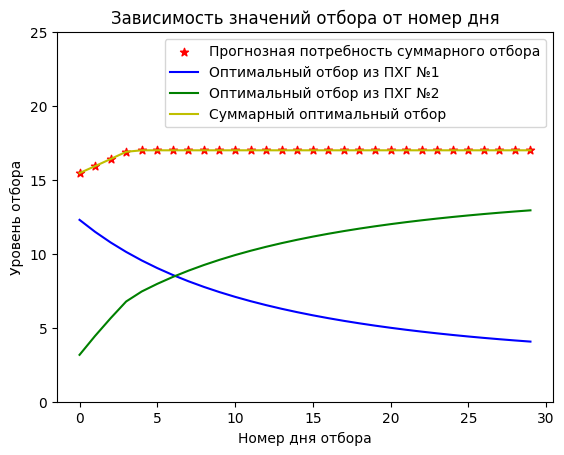

In [124]:
plt.scatter(df_final.index.tolist(), df_final['forecast'], c='r', marker='*')
plt.plot(df_final.index.tolist(), df_final['phg1_extract'], c='b')
plt.plot(df_final.index.tolist(), df_final['phg2_extract'], c='g')
plt.plot(df_final.index.tolist(), df_final['phg1_extract'] + df_final['phg2_extract'], c='y')
plt.xlabel('Номер дня отбора')
plt.ylabel('Уровень отбора')
plt.legend(['Прогнозная потребность суммарного отбора', 'Оптимальный отбор из ПХГ №1', 
            'Оптимальный отбор из ПХГ №2', 'Суммарный оптимальный отбор'])
plt.title('Зависимость значений отбора от номер дня')
plt.ylim([0, 25])
plt.show()

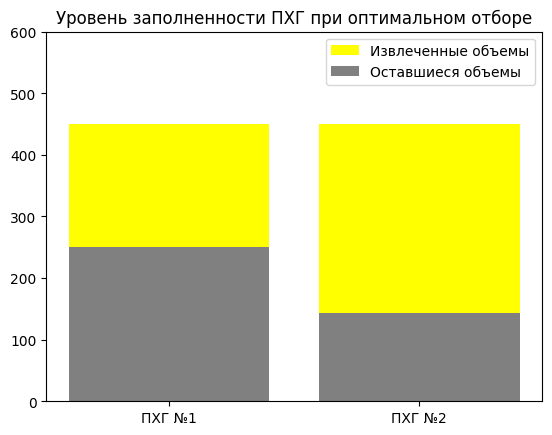

In [125]:
x = ['ПХГ №1', 'ПХГ №2']
y1 = [450, 450]
y2 = [df_final['phg1_left'][-1:].values[0], df_final['phg2_left'][-1:].values[0]]
 
plt.bar(x, y1, color='yellow')
plt.bar(x, y2, color='grey')
plt.title('Уровень заполненности ПХГ при оптимальном отборе')
plt.legend(['Извлеченные объемы', 'Оставшиеся объемы'])
plt.ylim([0, 600])
plt.show()